In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import re
import os
%matplotlib inline

In [2]:
# Which downsampling norm to use: This selects input data:
# dd: Deduplicated downsampled data
# aa: Analyse all reads in data, downsample based on number of PF reads
DS_MODE = "aa"

# Alignment notes

Alignment with bwa-mem.

The minimum seed length is 19.

Maximum gap length: 100.

## Load Picard data

### Step 1 is to load all the metrics from the downsampled data.

In [3]:
def load_picard(path):
    with open(path) as f:
        mode = None
        metrics_header = None
        metrics_data = {}
        histogram_series = []
        histogram_data = []
        for l in f:
            line = l.rstrip("\r\n")
            if mode == 'metrics':
                metrics_header = line.split()
                mode = 'metrics2'
            elif mode == 'metrics2':
                if line != "":
                    metrics_data = dict(zip(metrics_header, line.split()))
                else:
                    mode = None
            elif mode == 'histogram':
                histogram_series = line.split()
                histogram_data = [list() for _ in histogram_series]
                mode = 'histogram2'
            elif mode == 'histogram2':
                if line != "":
                    for i, value in enumerate(line.split()):
                        histogram_data[i].append(value)
                else:
                    mode = None
            elif line.startswith("## METRICS CLASS"):
                mode = 'metrics'
            elif line.startswith("## HISTOGRAM"):
                mode = 'histogram'
        if histogram_series:
            #metrics_data['histograms'] = dict(zip(histogram_series, histogram_data))
            for name, data in zip(histogram_series, histogram_data):
                metrics_data[name] = [float(x) for x in data]
    return metrics_data

In [4]:
samples = []
for bam in glob("30_downsample/*-{}_DS_MD.AlignmentSummaryMetrics.txt".format(DS_MODE)):
    basepath = re.sub(r"_MD\.AlignmentSummaryMetrics\.txt$", "", bam)
    data = {}
    try:
        for metrics in ['_MD.AlignmentSummaryMetrics', '_MD.InsertSizeMetrics',
                        '.MarkDuplicatesMetrics', '_MD.WgsMetrics']:
            new_data = load_picard("{}{}.txt".format(basepath, metrics))
            if any(k in data for k in new_data):
                print("Duplicate key {} found in {}".format(k, metrics))
            data.update(new_data)
    except FileNotFoundError as e:
        print("File {} not found, skipping this sample.".format(e.filename))
        continue
    samples.append(data)

In [5]:
print(len(samples))

48


### Step 2: Get original number of PF reads from before downsampling.

In [6]:
inital_read_counts = []
for alignment_txt in glob("20_piccard/*.AlignmentSummaryMetrics.txt"):
    library = re.match(r"([^/]+)\.AlignmentSummaryMetrics.txt", os.path.basename(alignment_txt)).group(1)
    new_data = load_picard(alignment_txt)
    inital_read_counts.append({'LIBRARY': library, 'INITIAL_READS': int(new_data['TOTAL_READS']),
                                    'INITIAL_READS_PER_END': int(new_data['TOTAL_READS']) / 2,
                                    'INITIAL_READS_ALIGNED': int(new_data['PF_READS_ALIGNED']),
                                    'INITIAL_READS_ALIGNED_PER_END': int(new_data['PF_READS_ALIGNED']) / 2})

In [7]:
dedup_read_counts = []
for rc_txt in glob("20_piccard_dd/*.readCount.txt"):
    library = re.match(r"([^/]+)\.readCount\.txt", os.path.basename(rc_txt)).group(1)
    rc = int(open(rc_txt).read().strip())
    dedup_read_counts.append({'LIBRARY': library, 'DEDUPLICATED_READS': rc, 'DEDUPLICATED_READS_PER_END': rc/2})

### Step 3: Get arabidopsis metrics.

In [8]:
arabidopsis_samples = []
for bam in glob("arabidopsis/20_piccard/*.bam"):
    basepath = re.sub(r"\.bam$", "", bam)
    data = {}
    for metrics in ['.AlignmentSummaryMetrics', '.InsertSizeMetrics',
                    '.MarkDuplicatesMetrics', '.WgsMetrics']:
        new_data = load_picard("{}{}.txt".format(basepath, metrics))
        if any(k in data for k in new_data):
            print("Duplicate key {} found in {}".format(k, metrics))
        data.update(new_data)
    arabidopsis_samples.append(data)

In [9]:
print(samples[0]['LIBRARY'])
#print(inital_read_counts[0]['LIBRARY'])
print("TODO. There is no arabidopsis yet.")

Nextera-10ng-1
TODO. There is no arabidopsis yet.


In [10]:
main_df = pd.DataFrame(samples).reindex().apply(pd.to_numeric, axis=0, errors='ignore')
in_reads_df = pd.DataFrame(inital_read_counts)
dd_reads_df = pd.DataFrame(dedup_read_counts)
arabidopsis_df = pd.DataFrame(arabidopsis_samples).apply(pd.to_numeric, axis=0, errors='ignore')


# Without Arabidopsis data
if arabidopsis_df.empty:
    df = pd.merge( 
        pd.merge(
            main_df, 
            in_reads_df,  
            on='LIBRARY').reindex(), 
        dd_reads_df,  
        on='LIBRARY')
else: # With Arabidopsis
    df = pd.merge( 
        pd.merge( 
            pd.merge( 
                main_df, 
                arabidopsis_df, 
                on='LIBRARY', suffixes=('', '_AR')).reindex(), 
            in_reads_df,  
            on='LIBRARY').reindex(), 
        dd_reads_df,  
        on='LIBRARY')
    df.dtypes[0:10]

In [11]:
df['Kit'] = pd.Categorical(df.LIBRARY.str.split("-").str.get(0))
df['Conc'] = pd.Categorical(df.LIBRARY.str.split("-").str.get(1))
df_100 = df.loc[df.Conc == "100ng"]
df.head(n=1)

,All_Reads.fr_count,BAD_CYCLES,BIN,CATEGORY,ESTIMATED_LIBRARY_SIZE,GENOME_TERRITORY,HET_SNP_Q,HET_SNP_SENSITIVITY,LIBRARY,MAD_COVERAGE,...,non_optical_sets,optical_sets,INITIAL_READS,INITIAL_READS_ALIGNED,INITIAL_READS_ALIGNED_PER_END,INITIAL_READS_PER_END,DEDUPLICATED_READS,DEDUPLICATED_READS_PER_END,Kit,Conc
0,"[401.0, 396.0, 744.0, 398.0, 466.0, 608.0, 554...",0,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",PAIR,2138778317,2934876545,9,0.878989,Nextera-10ng-1,2,...,"[83995523.0, 1132112.0, 65611.0, 23835.0, 1216...","[0.0, 1207068.0, 12263.0, 224.0, 44.0, 18.0, 1...",449238456,441568539,220784269.5,224619228.0,434083158,217041579.0,Nextera,10ng


In [12]:
print("Number of entries: ", len(df))

Number of entries:  40


# Number of reads

Number of PE reads (reads per end):

In [13]:
df['TOTAL_READS_PER_END'] = df['TOTAL_READS'] / 2
num_reads_downsampled = df.TOTAL_READS_PER_END.mean()
num_reads_initial = df.INITIAL_READS_PER_END.mean()
num_reads_deduplicated = df.DEDUPLICATED_READS_PER_END.mean()
print("One lane of HiSeqX:       {:9d} (optimistic)".format(400000000))
print("Initial reads (avg):      {:9d}".format(int(num_reads_initial)))
print("Deduplicated reads (avg): {:9d}".format(int(num_reads_deduplicated)))
print("Downsampled reads:        {:9d}".format(int(num_reads_downsampled)))

One lane of HiSeqX:       400000000 (optimistic)
Initial reads (avg):      198559655
Deduplicated reads (avg): 187794457
Downsampled reads:         89999584


Experiment set-up:

One pool for each kit. There are 8 libraries in each pool. The pool is sequenced on four lanes. Each library gets a half lane's worth of reads on average.

The mean read count per library is around half of the expected 200M, because of less than optimal yield, and inevitable differences between samples in the pool.

The "downsampled" in the table above depends on the constant set at the top of this notebook. It is either based on the lowest Initial reads (aa) or the lowest Deduplicated reads (dd).

In [14]:
print(DS_MODE)

aa


Downsampling is based on the following read counts: aa=INITIAL, dd=DEDUPLICATED.

The point with the fewest reads represents the value used for downsampling (after rounding down).

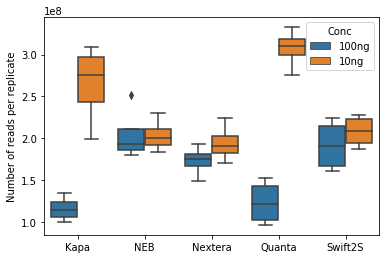

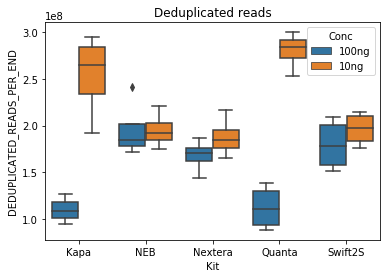

Text(0.5,1,'Downsampled reads')

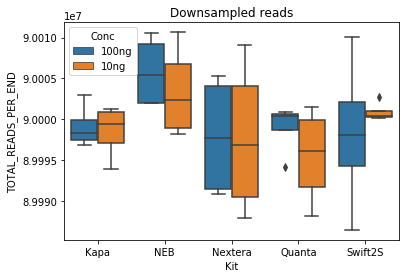

In [15]:
sns.boxplot(data=df, x='Kit', y='INITIAL_READS_PER_END', hue='Conc')
plt.ylabel('Number of reads per replicate')
plt.xlabel("")
plt.savefig("plots/total_number_of_reads.pdf")
plt.show()
sns.boxplot(data=df, x='Kit', y='DEDUPLICATED_READS_PER_END', hue='Conc')
plt.title('Deduplicated reads')
plt.show()
sns.boxplot(data=df, x='Kit', y='TOTAL_READS_PER_END', hue='Conc')
plt.title('Downsampled reads')

In [16]:
df[(df.Kit=='Swiftlong') & (df.Conc == '100ng')].PF_READS/2

Series([], Name: PF_READS, dtype: float64)

# Aligned reads

In [17]:
print([col for col in list(df) if 'ALIGNED' in col.upper()])

['PCT_PF_READS_ALIGNED', 'PCT_READS_ALIGNED_IN_PAIRS', 'PF_ALIGNED_BASES', 'PF_HQ_ALIGNED_BASES', 'PF_HQ_ALIGNED_Q20_BASES', 'PF_HQ_ALIGNED_READS', 'PF_READS_ALIGNED', 'READS_ALIGNED_IN_PAIRS', 'INITIAL_READS_ALIGNED', 'INITIAL_READS_ALIGNED_PER_END']


## Plot of any aligned reads

Text(0.5,0,'')

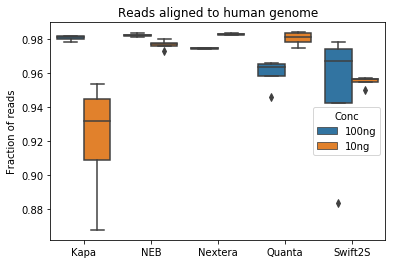

In [18]:
sns.boxplot(data=df, x='Kit', y='PCT_PF_READS_ALIGNED', hue='Conc')
plt.title('Reads aligned to human genome')
plt.ylabel("Fraction of reads")
plt.xlabel("")

## Plots for MAPQ > 20 reads

Requiring MAPQ > 20 removes a large percentage of reads. We found a lot of reads that map to both references.

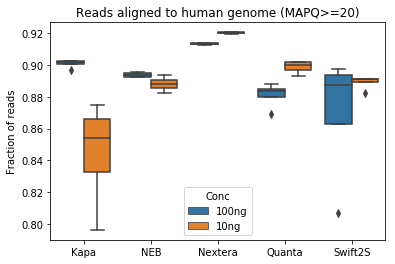

In [19]:
df['PCT_HQ_PF_READS_ALIGNED'] = df.PF_HQ_ALIGNED_READS / df.TOTAL_READS
sns.boxplot(data=df, x='Kit', y='PCT_HQ_PF_READS_ALIGNED', hue='Conc')
plt.title('Reads aligned to human genome (MAPQ>=20)')
plt.ylabel("Fraction of reads")
plt.xlabel("")
plt.savefig("plots/aligned_reads_human.pdf")

In [20]:
print("Low aligned rate")
df[df.PCT_HQ_PF_READS_ALIGNED < 0.88][["LIBRARY", "PCT_HQ_PF_READS_ALIGNED"]]

Low aligned rate


,LIBRARY,PCT_HQ_PF_READS_ALIGNED
7,Kapa-10ng-4,0.862983
9,Swift2S-100ng-2,0.806933
21,Kapa-10ng-1,0.844976
34,Kapa-10ng-3,0.796385
37,Kapa-10ng-2,0.874893
39,Quanta-100ng-3,0.869327


In [21]:
# Correct the aligned pct. All reads in the AR dataset are aligned.
if not arabidopsis_df.empty:
    df['PCT_HQ_PF_READS_ALIGNED_AR'] = df.PF_HQ_ALIGNED_READS_AR / df.INITIAL_READS
    sns.boxplot(data=df, x='Kit', y='PCT_HQ_PF_READS_ALIGNED_AR', hue='Conc')
    plt.title('Reads aligned to Arabidopsis Lyrata genome (MAPQ >= 20)')
    plt.ylabel("Fraction of reads")
    plt.xlabel("")
    plt.savefig("plots/aligned_reads_arabidopsis.pdf")

## Show arabidopsis in same plot

In [22]:
if not arabidopsis_df.empty:
    grid = sns.boxplot(data=df, x='Kit', y='PCT_HQ_PF_READS_ALIGNED', hue='Conc', linewidth=0.5, fliersize=3)
    grid.legend().remove()
    sns.boxplot(data=df, x='Kit', y='PCT_HQ_PF_READS_ALIGNED_AR', hue='Conc', linewidth=0.5, fliersize=3)
    plt.ylim(0,1)
    plt.savefig("plots/aligned_reads_both.pdf")

Alternative way to do combined plot here -- not used:

In [23]:
if not arabidopsis_df.empty:
    #df['PCT_HQ_PF_READS_ALIGNED_AR'] = df.PF_HQ_ALIGNED_READS_AR / df.INITIAL_READS
    #df['PCT_HQ_PF_READS_ALIGNED'] = df.PF_HQ_ALIGNED_READS / df.TOTAL_READS
    hdf = pd.DataFrame(df)
    hdf['Value'] = hdf.PCT_HQ_PF_READS_ALIGNED
    hdf['Species'] = "Human"
    adf = pd.DataFrame(df)
    adf['Value'] = adf.PCT_HQ_PF_READS_ALIGNED_AR
    adf['Species'] = "Arabidopsis"
    combined = pd.concat([adf, hdf])

Show details for one sample. This is to determine why there is so many reads aligned to both arabidopsis and human at the same time. This was never completely solved, but we see that the problem goes away when requiring a moderate mapping quality (20).

In [24]:
if not arabidopsis_df.empty:
    sample = df[df['LIBRARY'] == 'NEB-10ng-1'].iloc[0]
    print("sample:", sample.LIBRARY)
    print("initial read:", sample.INITIAL_READS)
    print("initial (pre-DS) reads aligned to human genome: {} ({:.1f} %)".format(
          sample.INITIAL_READS_ALIGNED, (sample.INITIAL_READS_ALIGNED * 100 / sample.INITIAL_READS)))
    print("reads aligned to arabidopsis genome: {} ({:.1f} %)".format(
            sample.PF_READS_ALIGNED_AR, (sample.PF_READS_ALIGNED_AR * 100 / sample.INITIAL_READS)) )
    FLAG_2_NREADS_NEB_10ng_1 = 89977265# Filtered on SAM flag 2
    assert sample.LIBRARY == "NEB-10ng-1"
    print("reads aligned PROPER PAIR to arabidopsis: {} ({:.1f} %)".format(
            FLAG_2_NREADS_NEB_10ng_1, (FLAG_2_NREADS_NEB_10ng_1 * 100 /sample.INITIAL_READS)) )

### Mapping quality technical definition

$$
MQ = -\log_{10} \left( 1.0 - \frac{10^{-SUM\_BASE\_Q(best)}}{\sum_i 10^{-SUM\_BASE\_Q(i)}} \right)
$$



The mapping quality definition is defined based on the sum of base qualities of **mismatching bases**, as compared to the reference.

The fraction above compares the mismatching base quality at the best hit to the mismatching base qualities at the other possible hits.

### Mapping quality description

The mapping quality is defined as a Phred-scaled probability that the mapped position of the read is the single best location in the genome. The probability is computed based on the sum of Q-scores of bases in the read that do not match the reference. A high mapping quality signifies that the read is uniquely mapped and a good match to the reference. Most reads will have a mapping quality of 60, indicating this condition. A mapping quality of 20 indicates a probability of 99 % that the read is mapped uniquely and correctly. Multi-mapping reads will in general have mapping qualities close to zero.

### Why is the KAPA kit so bad at producing aligned reads?

The KAPA kit scores poorly on alignment, with a low percentage aligned, both using MAPQ cut-off or not.

KAPA has a very broad insert size distribution, almost not peaking. We can compare with Swift, which has such a distribution for 100 ng.

In [25]:
pd.DataFrame({
    "Kit": ["Kapa", "Kapa", "Swift", "Swift"],
    "Conc":["10ng", "100ng","10ng",  "100ng"],
    "Broad distribution": [True, True, False, True],
    "Bad align frac": [True, False, False, True],
    })

,Kit,Conc,Broad distribution,Bad align frac
0,Kapa,10ng,True,True
1,Kapa,100ng,True,False
2,Swift,10ng,False,False
3,Swift,100ng,True,True


The broad size distribution and bad alignment don't seem directly correlated.

# Insert size (Picard)

In [26]:
colours = sns.color_palette()
kits = df.Kit.cat.categories
KIT_COL = dict(zip(kits, colours))
print(KIT_COL)

{'Kapa': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'NEB': (1.0, 0.4980392156862745, 0.054901960784313725), 'Nextera': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), 'Quanta': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), 'Swift2S': (0.5803921568627451, 0.403921568627451, 0.7411764705882353)}


## Simple plot with read count

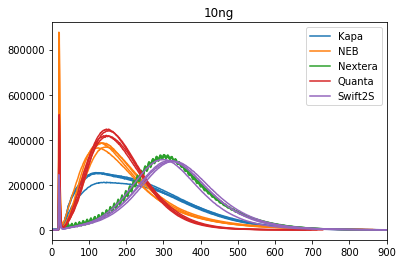

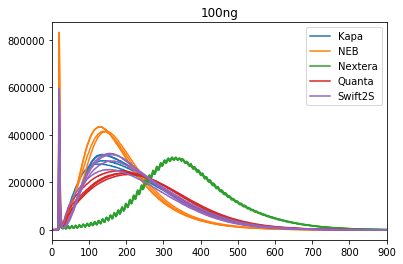

In [27]:
mean_insert_sizes = []
for conc in ["10ng", "100ng"]:
    legends = set()
    plt.figure()
    plt.xlim(0, 900)
    plt.title(conc)
    for kit, group in df[df.Conc==conc].groupby(("Kit"), as_index=False):
        colour = KIT_COL[kit]
        means = []
        for ix, (xs, ys) in group[['insert_size', 'All_Reads.fr_count']].iterrows():
            if not kit in legends:
                plt.plot(xs, ys, color=colour, label=kit)
                legends.add(kit)
            else:
                plt.plot(xs, ys, color=colour)
            # Mean
            values = np.array(xs)
            weights = np.array(ys)
            mean = sum(weights*values) / sum(weights)
            means.append(mean)
        mean_insert_sizes.append((conc, kit, sum(means) / len(means)))
            
    plt.legend()
    # Saving the next plot instead
    #plt.savefig("plots/insert_size_{}.pdf".format(conc))

### Plot with range

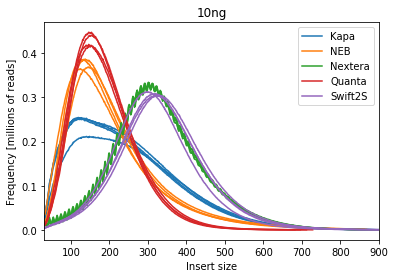

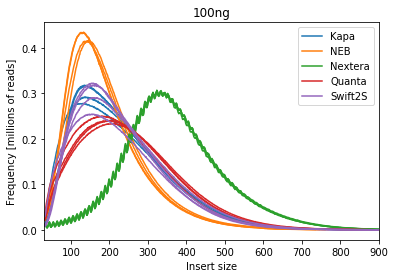

In [28]:
for conc in ["10ng", "100ng"]:
    legends = set()
    plt.figure()
    plt.xlim(30, 900)
    plt.title(conc)
    for kit, group in df[df.Conc==conc].groupby(("Kit"), as_index=False):
        colour = KIT_COL[kit]
        means = []
        for ix, (xs, ys) in group[['insert_size', 'All_Reads.fr_count']].iterrows():
            x_sel = xs[30:]
            y_sel = np.array(ys[30:])
            y_sel = y_sel / 1e6 # y_sel.sum()
            if not kit in legends:
                plt.plot(x_sel, y_sel, color=colour, label=kit)
                legends.add(kit)
            else:
                plt.plot(x_sel, y_sel, color=colour)
    plt.legend()
    plt.xlabel("Insert size")
    plt.ylabel("Frequency [millions of reads]")
    plt.savefig("plots/insert_size_{}.pdf".format(conc))

In [29]:
for vvv in mean_insert_sizes:
    print(*vvv, sep="\t")

10ng	Kapa	240.37577007672678
10ng	NEB	206.29597875568518
10ng	Nextera	325.69439176603976
10ng	Quanta	185.64309429497627
10ng	Swift2S	330.023012703364
100ng	Kapa	227.6172505011575
100ng	NEB	188.4679381532349
100ng	Nextera	366.03950116954775
100ng	Quanta	244.03309622459943
100ng	Swift2S	225.8970094550177


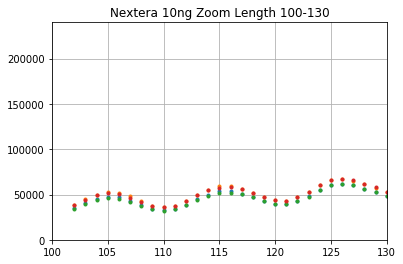

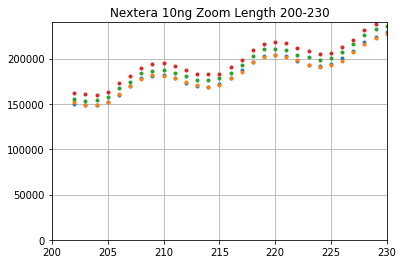

In [30]:
nextera10_samples = df[(df.Conc=="10ng") & (df.Kit=="Nextera")]
plt.figure()
plt.xlim(100, 130)
plt.ylim(0, 240000)
plt.title("Nextera 10ng Zoom Length 100-130")
nextera10_samples[['insert_size', 'All_Reads.fr_count']].apply(
            lambda x: plt.plot(*x.apply(lambda x: x[100:130]), '.'), 
    axis=1)
plt.grid()
plt.savefig("plots/nextera_insert_size_100.pdf")
plt.figure()
plt.xlim(200, 230)
plt.ylim(0, 240000)
plt.title("Nextera 10ng Zoom Length 200-230")
nextera10_samples[['insert_size', 'All_Reads.fr_count']].apply(
            lambda x: plt.plot(*x.apply(lambda x: x[200:230]), '.'), 
    axis=1)
plt.grid()
plt.savefig("plots/nextera_insert_size_200.pdf")

The period of the oscillations is approximately 10 bases. The magnitude is approximately 10000 reads, similar in both size ranges, less fraction of the reads at 200.

## Short fragments

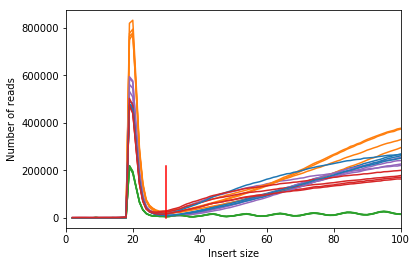

In [31]:
SHORT_FRAG = 28
for i, row in df_100.iterrows():
    col = KIT_COL[row.Kit]
    plt.plot(row['insert_size'], row['All_Reads.fr_count'], color=col)
plt.plot(
    [df['insert_size'][0][SHORT_FRAG], df['insert_size'][0][SHORT_FRAG]],
    [0, max(df['All_Reads.fr_count'][0][0:SHORT_FRAG])],
    'r'
    )
plt.xlim(0, 100)
plt.xlabel("Insert size")
plt.ylabel("Number of reads")
plt.savefig("plots/short_insert_zoom_100ng.pdf")

In [32]:
df['short_fragments_pct'] = df['All_Reads.fr_count'].map(lambda x: sum(x[0:SHORT_FRAG]) * 100.0 / sum(x))

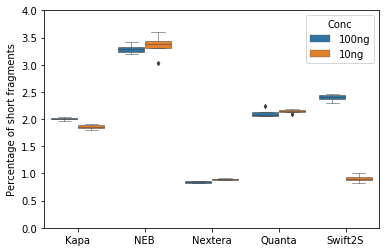

In [33]:
sns.boxplot(data=df, x='Kit', y='short_fragments_pct', hue='Conc', linewidth=0.5, fliersize=3)
plt.ylim(0, 4)
plt.ylabel("Percentage of short fragments")
plt.xlabel("")
plt.savefig("plots/short_fragments_fraction.pdf")

The peak at short fragment lengths looks serious, but only accounts for max. 4 % of the reads. NEB has more such reads.

## Insert size related summary tables

In [34]:
def get_mean(row):
    values = row['insert_size']
    freqs = row['All_Reads.fr_count']
    mean = sum(v*f for v, f in zip(values, freqs)) / sum(freqs)

def get_median(row):
    values = row['insert_size']
    freqs = row['All_Reads.fr_count']
    midpoint = sum(freqs) / 2
    acc = 0
    loc = 0
    while loc < len(freqs):
        acc += freqs[loc]
        if acc > midpoint:
            return values[loc]
        loc += 1
    return values[-1]



In [35]:
df.groupby(["Conc", "Kit"])[['short_fragments_pct', 'MEDIAN_INSERT_SIZE', 'MEAN_INSERT_SIZE', 'MEDIAN_ABSOLUTE_DEVIATION', 'STANDARD_DEVIATION']].mean()

short_fragments_pct  MEDIAN_INSERT_SIZE  MEAN_INSERT_SIZE  \
Conc  Kit                                                                  
100ng Kapa                2.003648              205.50        227.617251   
      NEB                 3.295514              169.50        188.467938   
      Nextera             0.844470              354.25        366.039501   
      Quanta              2.106863              228.75        244.033096   
      Swift2S             2.396811              205.75        225.897009   
10ng  Kapa                1.859324              218.25        240.375770   
      NEB                 3.352254              178.25        206.295979   
      Nextera             0.895811              317.50        325.694392   
      Quanta              2.142580              174.50        185.643094   
      Swift2S             0.904034              324.75        330.023013   

               MEDIAN_ABSOLUTE_DEVIATION  STANDARD_DEVIATION  
Conc  Kit                                                     
100ng Kapa                         81.00          126.198755  
      NEB                          58.25          102.913832  
      Nextera                      79.25          133.441441  
      Quanta                       87.25          130.934422  
      Swift2S                      78.50          122.761322  
10ng  Kapa                         93.50          139.740174  
      NEB                          67.25          127.047509  
      Nextera                      72.75          121.681407  
      Quanta                       53.00           85.511150  
      Swift2S                      71.25          117.832573

### TODO.maybe: reproducibility of insert size between replicates

# Duplicated reads

This plot shows library duplication rate. The optical duplicates are also counted if the dataset mode is "aa" (analyse all).

(0, 6)

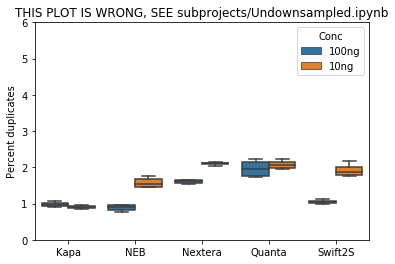

In [36]:
df['PERCENT_DUPLICATION_NON_OPTICAL'] = (
        (df.READ_PAIR_DUPLICATES - df.READ_PAIR_OPTICAL_DUPLICATES)*2 + df.UNPAIRED_READ_DUPLICATES
        ) * 100.0 / (
        df.READ_PAIRS_EXAMINED*2 + df.UNPAIRED_READS_EXAMINED
        )
sns.boxplot(data=df, x='Kit', y='PERCENT_DUPLICATION_NON_OPTICAL', hue='Conc')
#plt.title("Non-optical duplicates")
plt.ylabel("Percent duplicates")
plt.xlabel("")
plt.title("THIS PLOT IS WRONG, SEE subprojects/Undownsampled.ipynb")
plt.ylim(0, 6)
###plt.savefig("plots/non_optical_duplicates.pdf")
### NOTE: Do not use this plot. The duplication rate is signficantly distorted by downsampling.
###       Use notebook subprojects/Undownsampled.ipynb

### Problem 1: why does Quanta have so many dupes? 100ng has no PCR!


Quanta


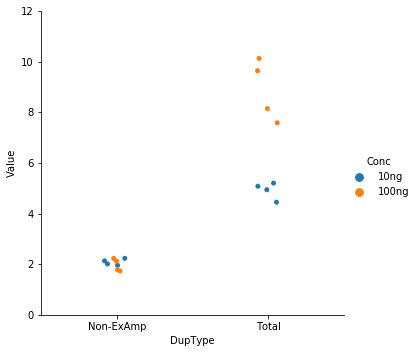

Swift2S


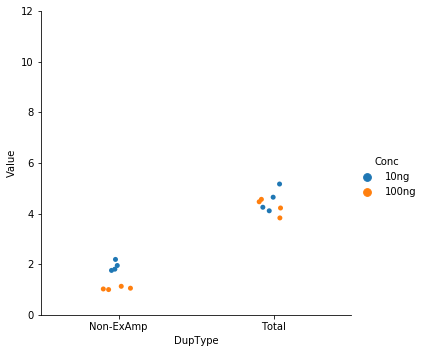

In [37]:
quanta = df[(df.Kit == 'Quanta')]
swift = df[(df.Kit == 'Swift2S')]
for kdf in [quanta, swift]:
    print(kdf.Kit.iloc[0])
    dfs = []
    for conc in ['10ng', '100ng']:
        quanta_dup = pd.DataFrame({'Value': kdf[kdf.Conc == conc]['PERCENT_DUPLICATION_NON_OPTICAL']})
        quanta_dup['DupType'] = 'Non-ExAmp'
        quanta_dup['Conc'] = conc
        dfs.append(quanta_dup)
        quanta_dup2 = pd.DataFrame({'Value': kdf[kdf.Conc == conc]['PERCENT_DUPLICATION']*100})
        quanta_dup2['DupType'] = 'Total'
        quanta_dup2['Conc'] = conc
        dfs.append(quanta_dup2)
    cat = pd.concat(dfs)
    sns.catplot(data=cat, x="DupType", y="Value", hue="Conc")
    plt.ylim(0, 12)
    plt.show()


In [38]:
quanta[quanta.Conc=='100ng'][['LIBRARY', 'PERCENT_DUPLICATION_NON_OPTICAL']]

,LIBRARY,PERCENT_DUPLICATION_NON_OPTICAL
10,Quanta-100ng-4,2.227406
27,Quanta-100ng-1,1.732827
33,Quanta-100ng-2,2.119822
39,Quanta-100ng-3,1.776792


#### Question

The 10 ng and 100 ng libraries were pooled and sequenced together for each kit. For Quanta, the 10ng libraries had a significantly greater yield from the sequencing. One possible reason is that the 100ng libraries have a broader size distribution, while 10ng have a peak at small size, and the smaller fragments clustered more effectively.

The surpising observation is that the duplication called as "optical" by Picard is much greater in the 100ng libraries. The optical duplicates on HiSeq X are actually Ex-Amp-related duplicates, or well hoppers. The probability of well-hopping is related to the flow cell loading, which should obviously be the same for the entire lane. Either the longer fragments in Quanta-100ng have a higher chance to go hopping, or the duplication metric is distorted by the downsampling. See the notebook in subprojects/Undownsampled.ipynb to follow up this last possibility.

#### Answer

**The plot in Undownsampled notebook clearly confirms that the duplication rates are wrong in this notebook, and the error is produced by downsampling.** Use the plot in the other notebook!


# Genome coverage

Reference scale for coverage: HiSeqX single lane sequencing.

The PF reads spec for HiSeqX is 2.6 to 3.0 billion per flow cell, so 2.6 B should also provide a 30X genome.

In [39]:
print("*All quantities below in Million reads*")
reads_for_30x = 2.6 * 1000 / 8
print("PF reads per lane for 30X coverage, per end:", reads_for_30x)
expected_per_library_reads = (reads_for_30x * 4) / 8
print("Expected reads per library, 8 libraries over 4 lanes:", expected_per_library_reads)
actual_reads = df.TOTAL_READS.mean() // (2*1000000) # Divide by two, as TOTAL_READS counts both PE ends
print("Actual downsampled read count:", actual_reads)
expected_coverage_level = 30 * (actual_reads / reads_for_30x)
print("")
print("Expected coverage level based on read count:", expected_coverage_level)
print("")

*All quantities below in Million reads*
PF reads per lane for 30X coverage, per end: 325.0
Expected reads per library, 8 libraries over 4 lanes: 162.5
Actual downsampled read count: 89.0

Expected coverage level based on read count: 8.215384615384615



In [40]:
plot_max_cov = 16

In [41]:
test_sample = df.loc[1]

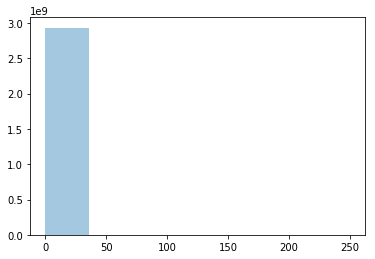

In [42]:
sns.distplot(test_sample['coverage'], kde=False,
             hist_kws={"weights":test_sample['high_quality_coverage_count']})

(0, 16)

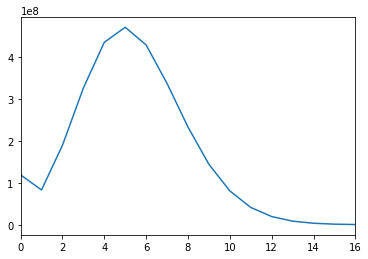

In [43]:
plt.plot(test_sample['coverage'], test_sample['high_quality_coverage_count'])
plt.xlim(0, plot_max_cov)

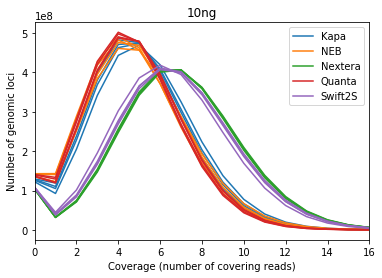

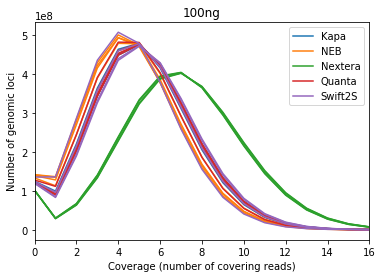

In [44]:

for conc in ["10ng", "100ng"]:
    legends = set()
    plt.xlim(0, plot_max_cov)
    plt.title(conc)
    plt.ylabel("Number of genomic loci")
    plt.xlabel("Coverage (number of covering reads)")

    for kit, group in df[df.Conc==conc].groupby("Kit", as_index=False):
        colour = KIT_COL[kit]
        for ix, (xs, ys) in group[['coverage', 'high_quality_coverage_count']].iterrows():
            if not kit in legends:
                plt.plot(xs, ys, color=colour, label=kit)
            else:
                plt.plot(xs, ys, color=colour)
            legends.add(kit)
    plt.legend()
    plt.savefig("plots/coverage_{}.pdf".format(conc))
    plt.show()

Number of entries, reads

In [45]:
for ix, sample in df.iterrows():
    hist_sum = sum(sample['high_quality_coverage_count'])
    hist_weighted_sum = sum(c * n for c, n in zip(sample['coverage'], 
                                                  sample['high_quality_coverage_count']))
    print(sample['LIBRARY'], "\t:\t", hist_sum, "\t / ", hist_weighted_sum)

NUM_GENOMIC_LOC = hist_sum

Nextera-10ng-1 	:	 2934876545.0 	 /  20271348219.0
Swift2S-100ng-3 	:	 2934876545.0 	 /  15556300398.0
Swift2S-10ng-4 	:	 2934876545.0 	 /  19700689539.0
NEB-100ng-1 	:	 2934876545.0 	 /  13659061660.0
Kapa-100ng-4 	:	 2934876545.0 	 /  15183477547.0
Nextera-100ng-3 	:	 2934876545.0 	 /  20505494456.0
Quanta-10ng-1 	:	 2934876545.0 	 /  13557298544.0
Kapa-10ng-4 	:	 2934876545.0 	 /  14752842533.0
Nextera-100ng-2 	:	 2934876545.0 	 /  20750275969.0
Swift2S-100ng-2 	:	 2934876545.0 	 /  13461382388.0
Quanta-100ng-4 	:	 2934876545.0 	 /  14928818338.0
Quanta-10ng-3 	:	 2934876545.0 	 /  13697567963.0
Nextera-100ng-1 	:	 2934876545.0 	 /  20819509558.0
NEB-100ng-3 	:	 2934876545.0 	 /  14274433368.0
Nextera-10ng-3 	:	 2934876545.0 	 /  20023618753.0
Swift2S-100ng-1 	:	 2934876545.0 	 /  14922441188.0
Quanta-10ng-2 	:	 2934876545.0 	 /  14045599261.0
NEB-10ng-4 	:	 2934876545.0 	 /  13606651698.0
Nextera-10ng-2 	:	 2934876545.0 	 /  20162174425.0
NEB-100ng-2 	:	 2934876545.0 	 /  137764785

# Cumulative coverage

In [46]:
df['cumulative_num_reads'] = df.high_quality_coverage_count.apply(np.cumsum)
df['cumulative_frac_reads'] = df.cumulative_num_reads.apply(lambda x: x / NUM_GENOMIC_LOC)

In [47]:
df.cumulative_num_reads.loc[3][-1] # Number of genomic loci

2934876545.0

/ypool/applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  del sys.path[0]


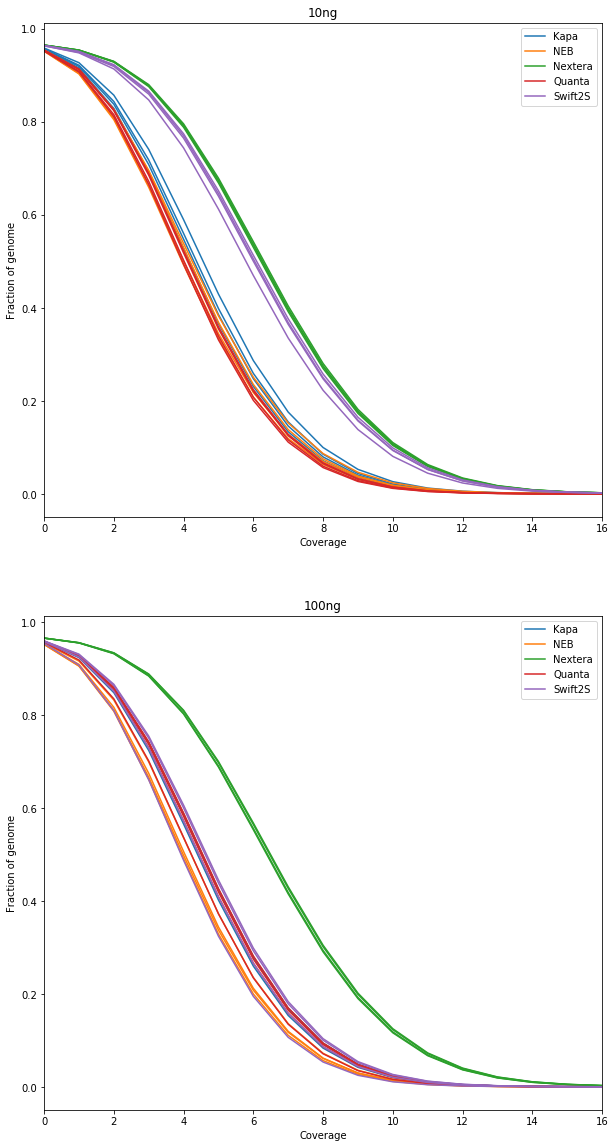

In [48]:
legends = set()

fig = plt.figure(figsize=(10, 20))
axs = {
    "10ng": fig.add_subplot(2, 1, 1),
    "100ng": fig.add_subplot(2, 1, 2)
}
for conc, ax in axs.items():
    ax.set_xlim(0, plot_max_cov)
    ax.set_title(conc)
    ax.set_ylabel("Fraction of genome")
    ax.set_xlabel("Coverage")
for (kit, conc), group in df.groupby(("Kit", "Conc"), as_index=False):
    colour = KIT_COL[kit]
    ax = axs[conc]
    for ix, (xs, yys) in group[['coverage', 'cumulative_frac_reads']].iterrows():
        ys = 1.0 - yys
        if not (ax, kit) in legends:
            ax.plot(xs, ys, color=colour, label=kit)
        else:
            ax.plot(xs, ys, color=colour)
        legends.add((ax, kit))
for ax in axs.values():
    ax.legend()

Text(0.5,0,'Coverage')

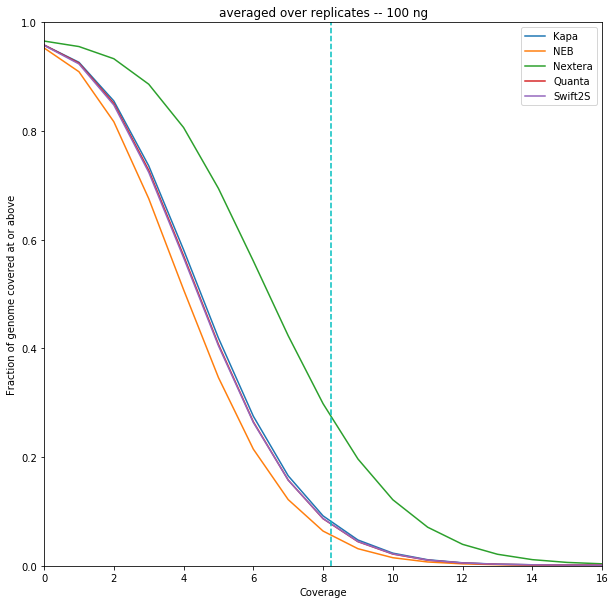

In [49]:
fig = plt.figure(figsize=(10, 10))


for kit, group in df[df.Conc=='100ng'].groupby("Kit", as_index=False):
    ys = 1.0 - np.mean(group['cumulative_frac_reads'])
    xs = group['coverage'].iloc[0]
    plt.plot(xs, ys, color=KIT_COL[kit], label=kit)

plt.legend()
plt.plot([expected_coverage_level, expected_coverage_level], [0.0,1.0], 'c--')
plt.xlim(0, plot_max_cov)
plt.ylim(0, 1)
plt.title("averaged over replicates -- 100 ng")
plt.ylabel("Fraction of genome covered at or above")
plt.xlabel("Coverage")


In [50]:
#list(df)

In [51]:
table = df_100.groupby('Kit')[
    ['MEAN_COVERAGE','MEDIAN_COVERAGE', 'PCT_1X',
     'PCT_10X', 'TOTAL_READS', 'INITIAL_READS']
    ].mean()
table

,MEAN_COVERAGE,MEDIAN_COVERAGE,PCT_1X,PCT_10X,TOTAL_READS,INITIAL_READS
Kit,,,,,,
Kapa,5.139712,5.00,0.957992,0.047469,179998242.0,231552363.5
NEB,4.704000,4.50,0.952627,0.031436,180011693.5,408351261.5
Nextera,7.039922,7.00,0.965307,0.196492,179995698.5,346128359.0
Quanta,5.073272,5.00,0.958027,0.044357,179997947.5,246424318.0
Swift2S,5.058357,4.75,0.957373,0.044794,179996364.0,382962926.5


The analysis was first done with a different reference, including ALTernative contigs. It's probably not a good idea to use these ALT contigs unless the whole pipeline takes them into account all the time.

Kit,MEAN_COVERAGE,MEDIAN_COVERAGE,PCT_1X,PCT_10X,TOTAL_READS
Kapa,4.84100525,5.0,0.90678325,0.044468,179998242.0
NEB,4.42826475,4.25,0.9013639999999999,0.0293165,180011693.5
Nextera,6.6390705,7.0,0.9147957499999999,0.1851845,179995698.5
Quanta,4.7782167499999995,5.0,0.9069119999999999,0.041523500000000005,179997947.5
Swift2S,4.76407625,4.75,0.9061827499999999,0.041947250000000005,179996364.0


In [52]:
#table.to_csv("")

In [53]:
print(df['coverage'][0][0])
print(df['high_quality_coverage_count'][0][0])

0.0
103717103.0


Note on interpretation of coverage histogram: 

In [54]:
# Aligned reads more detailed, todo
read_counts = []

for i, row in df.iterrows():
    library = {
        'LIBRARY': row.LIBRARY,
        'Kit': row.Kit,
        'Conc': row.Conc
    }
    read_counts.append(dict(
                        Reads=row.TOTAL_READS_PER_END,
                        Type='Downsampled',
                        **library))
    aligned = 1

# Coverage calculation